# Задача
## Инициализация
У нас есть сетка w на h с разными жителями. В нашей задаче 2 вида жителей n_red и n_blue. Также у нас есть порог удовлетворённости epsilon и максимальное количество шагов симуляций T. Мы случайно размещаем жителей в нашей сетке на свободные места.
## Симуляция
t = 0, ..., T-1
каждый житель считает количество соседей и тех, которые одного с ним цвета. Таким образом если рядом с жителем соседей его цвета > порога epsilon, то он удолетворён. В ином случае житель не удовлетворён.
Все неудовлетворённые жители перемещаются на случайные пустые клетки в момент времени t - 1.
На каждом шаге мы собираем следующую информацию:
* процент неудовлетворённых жителей
* средний процент соседей того же цвета

Если количество неудовлетворённых жителей стало равно нулю, то мы прекращаем симуляцию.
Каждые 10 шагов выводим график позиций наших жителей и heatmap удовлетворённости (зелёный цвет - удовлетворённые, а красный цвет - неудовлетворённые)
## Результат
График с время до стационарности в зависимости от порога epsilon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import copy

In [2]:
class SchellingModel:
    # TODO : We can add Можно добавить вместо n_red и n_blue просто param и это будет список разных видов резидентов.
    def __init__(self, width = 10, height = 10, epsilon = 0.5, n_red = 20, n_blue = 20):
        self.w = width
        self.h = height
        self.epsilon = epsilon
        self.n_red = n_red
        self.n_blue = n_blue
        self.color_map = {'empty': (255, 255, 255), 'red': (255, 0, 0), 'blue': (0, 0, 255)}
        self.unsatisfied_condition = lambda x: x / 8 < self.epsilon # if good neighbors / 8 less than epsiln than resident is unsatisfied of it position
        self.boundary_percent = 1 - 1e-5
        self.stats = pd.DataFrame(columns=['percent_unsatisfied', 'epsilon'])
        self.grid = self.generate_grid()

    def random_field_fill(self, grid_to_fill, n, empty_key, other_key):
        h = len(grid_to_fill)  # Getting the grid height
        w = len(grid_to_fill[0])  # Getting the grid width
        for _ in range(n):
            while True:
                x, y = random.randint(0, w - 1), random.randint(0, h - 1)
                if grid_to_fill[x][y] == empty_key:
                    grid_to_fill[x][y] = other_key
                    break

    def generate_grid(self):
        keys = list(self.color_map.keys())
        empty_key = keys[0]
        other_keys = keys[1:]
        generated_grid = [[empty_key for _ in range(self.w)] for _ in range(self.h)]

        self.random_field_fill(generated_grid, self.n_red, empty_key, other_keys[0])
        self.random_field_fill(generated_grid, self.n_red, empty_key, other_keys[1])

        return generated_grid
    def count_neighbors(self, x, y, grid, color):
        neighbors = 0
        subgrid = [row[max(y - 1, 0):min(y + 2, len(grid[0]))] for row in grid[max(x - 1, 0):min(x + 2, len(grid))]]
        for row in subgrid:
            for cell in row:
                if cell == color:
                    neighbors += 1
        neighbors -= 1  # Subtract 1 to exclude the central cell if it has the same color
        return neighbors

    def compare_arrays(self, array1, array2):
        if len(array1) != len(array2) or len(array1[0]) != len(array2[0]):
            return False
        for i in range(len(array1)):
            for j in range(len(array1[0])):
                if array1[i][j] != array2[i][j]:
                    return False
        return True

    def simulate_step(self, grid):
        temp_grid = grid
        unsatisfied = []
        n_unsatisfied = 0
        new_grid = copy.deepcopy(grid)
        
        for i in range(self.w):
            for j in range(self.h):
                inhabitant = temp_grid[i][j]
                if inhabitant != 'empty':
                    # As wariant: create satisfaction grid for checking only unsatisfied residents
                    n_neighbors = self.count_neighbors(i, j, temp_grid, inhabitant)
                    if self.unsatisfied_condition(n_neighbors):
                        unsatisfied.append((i, j))
                        n_unsatisfied += 1
        
        for _ in range(n_unsatisfied):
            x, y = random.randint(0, self.w - 1), random.randint(0, self.h - 1)
            while new_grid[x][y] != 'empty':
                x, y = random.randint(0, self.w - 1), random.randint(0, self.h - 1)
            if len(unsatisfied) > 1:
                i, j = unsatisfied.pop(random.randint(0, len(unsatisfied) - 1))
                inhabitant = temp_grid[i][j]
                new_grid[x][y] = inhabitant
                new_grid[i][j] = 'empty'

        new_grid_state = copy.deepcopy(new_grid)
        is_diff_state = not self.compare_arrays(temp_grid, new_grid)
        satisfied_percent = 1 - n_unsatisfied / (self.n_red + self.n_blue)
        return new_grid_state, is_diff_state, satisfied_percent

    def plot_grid(self):
        h = len(self.grid)  # Getting the grid height
        w = len(self.grid[0])  # Getting the grid width
        heatmap_data = [[0 for _ in range(w)] for _ in range(h)]
        for i in range(self.w):
            for j in range(self.h):
                inhabitant = self.grid[i][j]
                heatmap_data[i][j] = self.color_map[inhabitant]

        plt.imshow(heatmap_data)
        plt.axis('off')
        plt.title('Positions')
        plt.show()

    def plot_satisfaction_grid(self):
        satisfaction = [[0 if self.grid[i][j] == 'empty' else self.count_neighbors(i, j, self.grid, self.grid[i][j]) / 8 
                         for j in range(len(self.grid[0]))] for i in range(len(self.grid))]
        satisfaction_flipped = np.flipud(satisfaction)
        plt.imshow(satisfaction_flipped, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Satisfaction')
        plt.title('Residents Satisfaction Heatmap')
        plt.gca().invert_yaxis()
        plt.show()
    
    def simulate(self, T = 1000, plot_step = 100, is_check_changes = False, is_show_plots = True, is_show_stat = True):
        for i in range(0, T):
            self.grid, is_changed, percent_satisfied = self.simulate_step(self.grid)
            self.stats = pd.concat([self.stats, pd.DataFrame(
                {
                 'percent_satisfied':[percent_satisfied], 
                 'epsilon':[self.epsilon]
                }
                )], ignore_index=True)
            if i % plot_step == 0:
                if is_show_stat:
                    print(f'satisfied = {percent_satisfied}')
                if is_show_plots:
                    self.plot_grid()
                    self.plot_satisfaction_grid()
            if percent_satisfied > self.boundary_percent or is_check_changes and is_changed:
                if(is_check_changes and is_changed != True):
                    print(f"State is not changed from {i - 1} to {i}")
                if is_show_plots:
                    self.plot_grid()
                    self.plot_satisfaction_grid()
                break
    
    def regenerate_grid(self):
        self.grid = self.generate_grid()
    
    def clear_stats(self):
        self.stats = pd.DataFrame(columns=['percent_unsatisfied', 'epsilon'])

In [3]:
model = SchellingModel(50, 50, 0.5, 500, 500)

satisfied = 0.04500000000000004


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


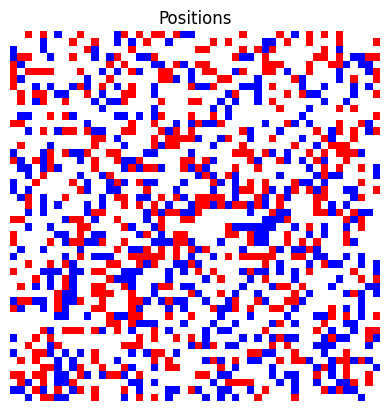

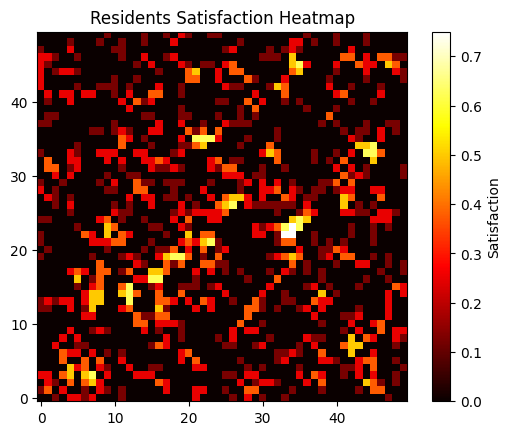

satisfied = 0.518


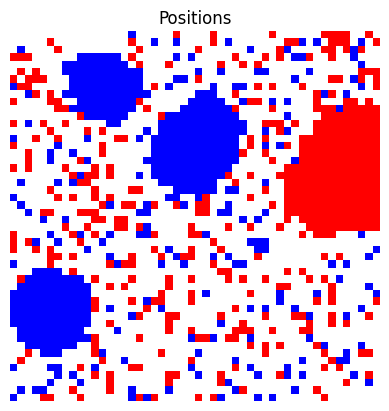

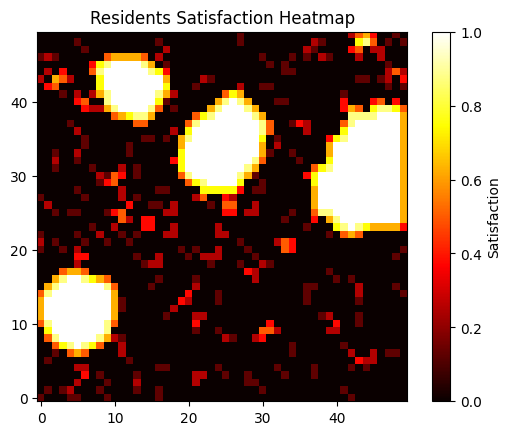

satisfied = 0.778


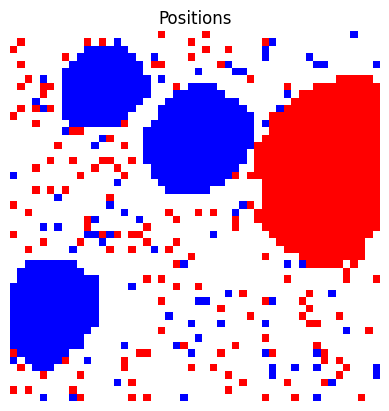

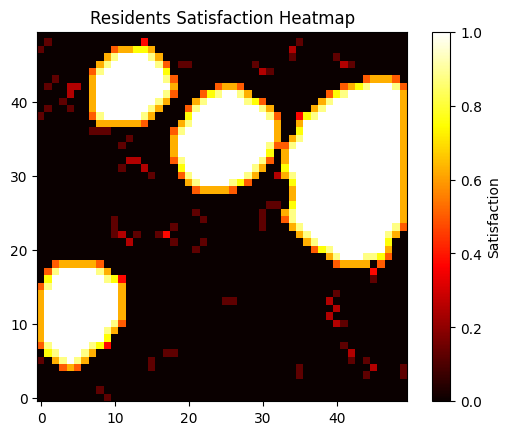

satisfied = 0.887


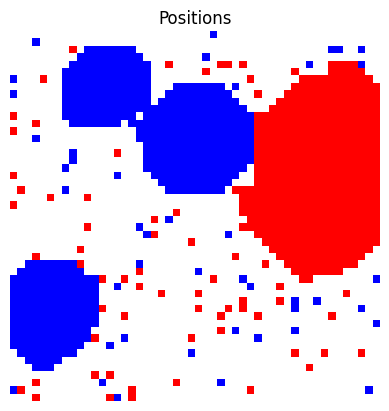

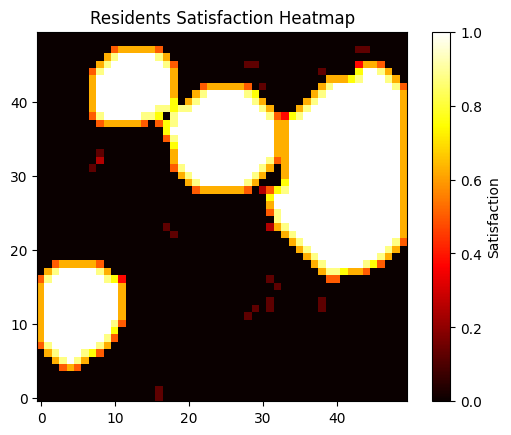

satisfied = 0.917


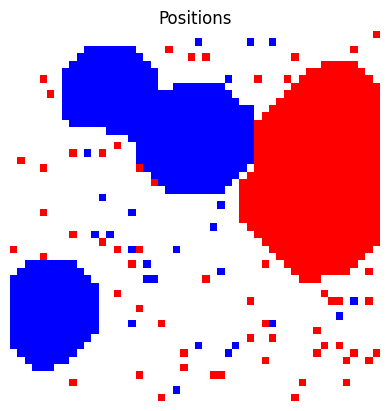

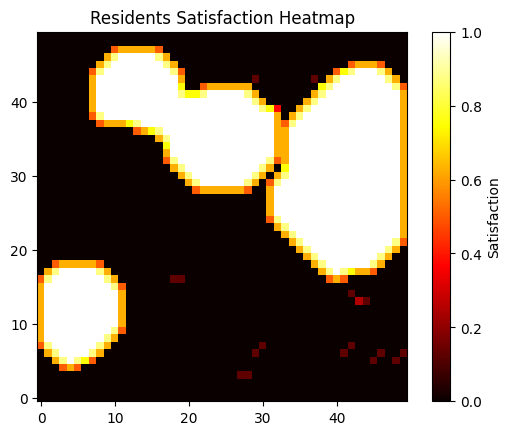

satisfied = 0.9390000000000001


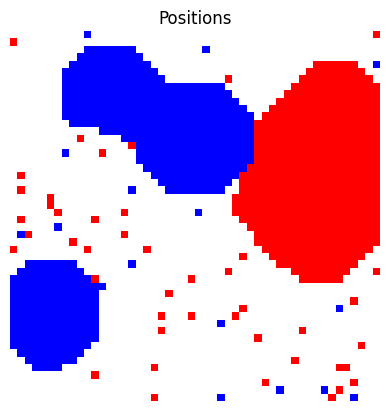

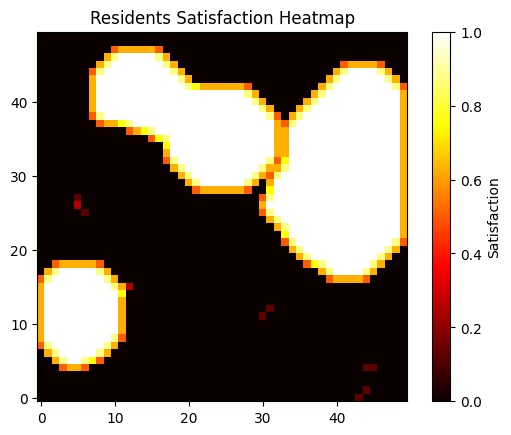

satisfied = 0.959


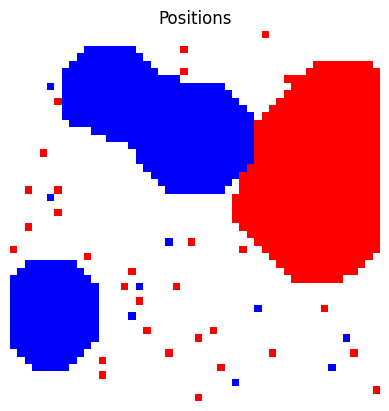

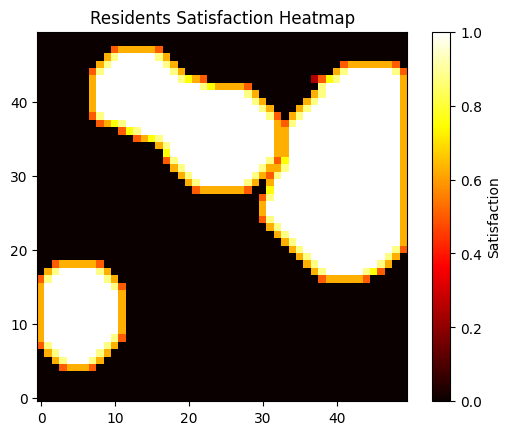

satisfied = 0.968


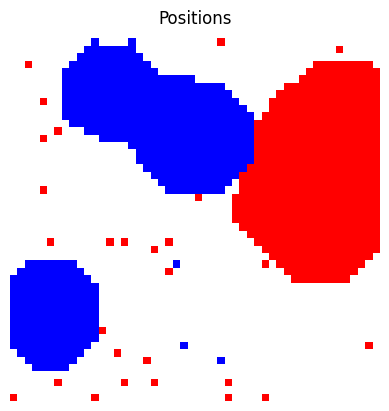

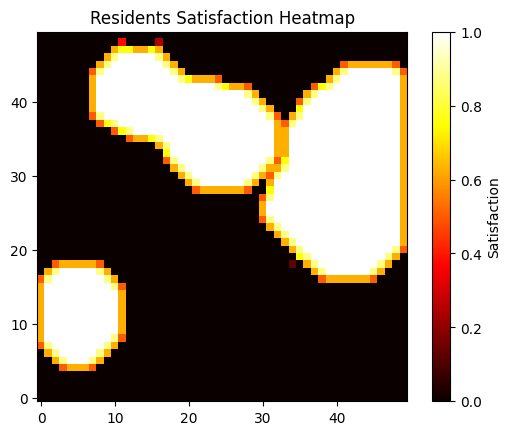

satisfied = 0.977


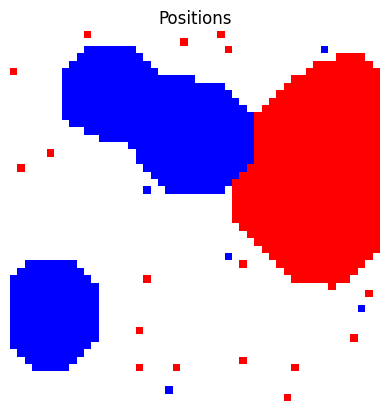

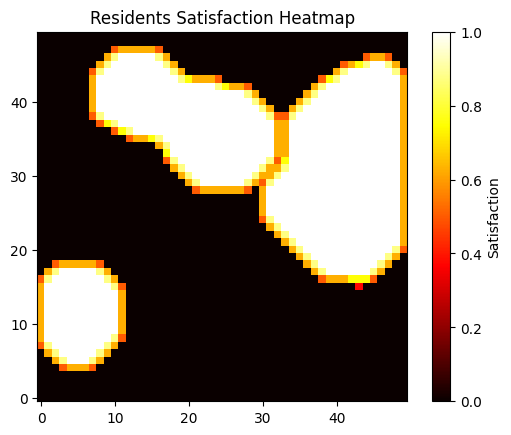

satisfied = 0.977


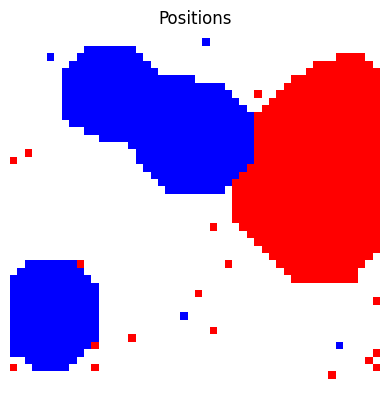

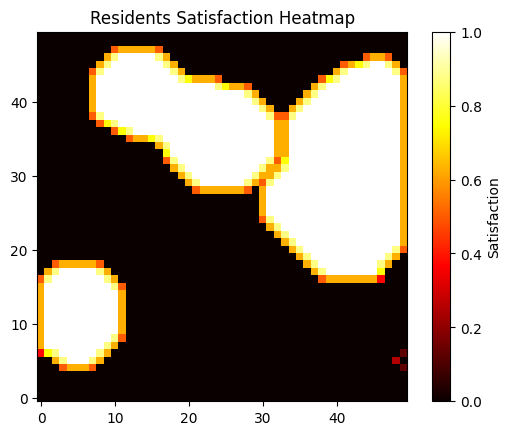

In [4]:
model.simulate()

## Тестирование модели при разных значениях epsilon

In [5]:
summary_stat = pd.DataFrame()
for i in range(0, 10):
    print(f"Simulation №{i} started")
    model = SchellingModel(50, 50, 0.1 * i, 500, 500)
    model.simulate(1000, 100, False, False, False)
    summary_stat = pd.concat([summary_stat, model.stats])
    print(f"Simulation №{i} ended")

Simulation №0 started
Simulation №0 ended
Simulation №1 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(
C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №1 ended
Simulation №2 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №2 ended
Simulation №3 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №3 ended
Simulation №4 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №4 ended
Simulation №5 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №5 ended
Simulation №6 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №6 ended
Simulation №7 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №7 ended
Simulation №8 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №8 ended
Simulation №9 started


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_19056\3111200217.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat([self.stats, pd.DataFrame(


Simulation №9 ended


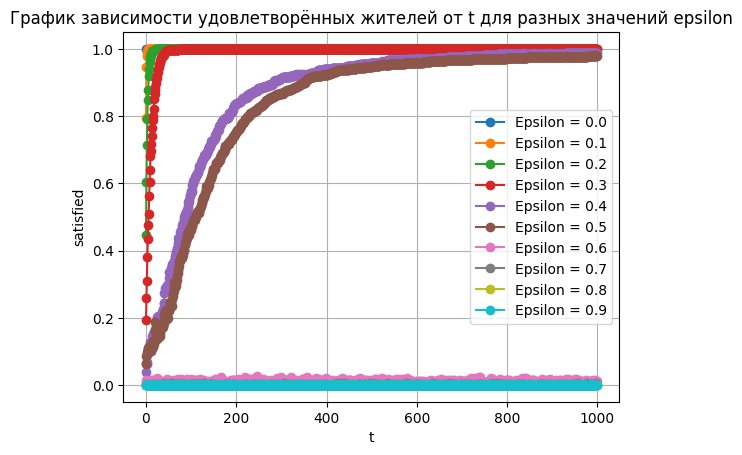

In [6]:
epsilons = summary_stat['epsilon'].unique()

for epsilon in epsilons:
    subset = summary_stat[summary_stat['epsilon'] == epsilon]
    
    plt.plot(subset.index, subset['percent_satisfied'], marker = 'o', linestyle = '-', label = f'Epsilon = {round(epsilon, 1)}')

plt.xlabel('t')
plt.ylabel('satisfied')
plt.title('График зависимости удовлетворённых жителей от t для разных значений epsilon')

plt.legend()

plt.grid(True)
plt.show()